## 1. Importing Libraries

In [24]:
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import nltk,re, pprint
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.chunk.regexp import *
from nltk.corpus import stopwords
from nltk.chunk.regexp import tag_pattern2re_pattern 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import state_union

## 2. Text Processing 
        This Step includes removing the stop words , tokenize the text to convert into sentences and converting each word into lower case.

In [36]:
# Set Parameters
n_clusters = 100    # No. Of Clusters
stop_words = set(stopwords.words('english'))
Actual_Summary = "output.txt"

def text_processing(file):
    f = open(file, 'r', encoding='utf-8')
    text = f.read()
    
    #Tokenization : Convert to sentences and then to words
    sentences = nltk.sent_tokenize(text)
    
    data = []
    for sent in sentences:
        words = nltk.word_tokenize(sent)
        words = [w.lower() for w in words if len(w)>2 and w not in stop_words]
        data.append(words)
        
    return data

text = text_processing("input.txt")
print("Text Processing : done")

Text Processing : done


## 3. Word2Vec Model 

In [37]:
from gensim.models import Word2Vec

model = Word2Vec(text, size=300, window = 10, min_count=1)
words = list(model.wv.vocab)

print("Word2Vec Model : done")

Word2Vec Model : done


/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


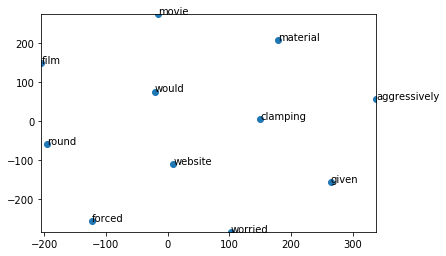

In [38]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    
display_closestwords_tsnescatterplot(model, words[0])

## 4. Spectral Clustering Applied

/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  # Remove the CWD from sys.path while we load stuff.
/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


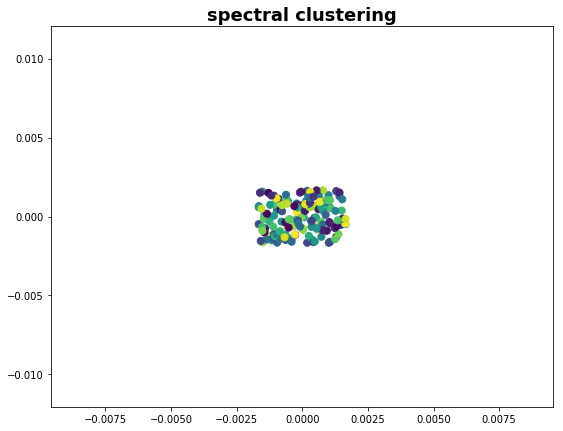

In [39]:
# Implement Spectral Clustering

from sklearn.cluster import SpectralClustering
dot_size=50
cmap = 'viridis'

model_spectral = SpectralClustering(n_clusters, affinity='nearest_neighbors', assign_labels='kmeans')

labels = model_spectral.fit_predict(model.wv.syn0)

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('spectral clustering', fontsize=18, fontweight='demi')
plt.scatter(model.wv.syn0[:, 0], model.wv.syn0[:, 1], c=labels, s=dot_size, cmap=cmap)


## 5. Applied K-Means and Regular Expression Parser

In [44]:
from scipy.spatial import distance
from sklearn.cluster import KMeans
import numpy as np

y_hc = []       
y_hc = labels.copy()              # Output Of Spectral Clustering : A list 
summary = []

print("***************************************************************************************************")

# Extracting The Keyword by choosing the mean of cluster
def Extracted_Keywords(clus, clus_name):
    
    kmeans = KMeans(n_clusters=1, random_state=0).fit(clus)
    labels = kmeans.labels_
    mean = kmeans.cluster_centers_.reshape(300,1)
    min_to_centre = []
    
    for i in clus:
        Y = distance.cdist(i.reshape(300,1), mean, 'euclidean')
        sum_Y = np.sum(Y)
        min_to_centre.append(sum_Y)

    min_value = min(min_to_centre)
    ind_value = np.argmin(min_to_centre)
    
#     print(ind_value)
#     print(clus_name[ind_value])  
    summary.append(clus_name[ind_value])
    
    
    
for j in range(0,100):
    clus = []
    clus_name = []
    count = 0
    for i in range(len(y_hc)):
        if(y_hc[i] == j):
            count += 1
            clus.append(model[words[i]])
            clus_name.append(words[i])
    
    Extracted_Keywords(clus, clus_name)
    
    
# print(nltk.pos_tag(summary))

# Grammar Regular Expression
grammar = "chunk:{(<JJ>)*(<NN | NNS | NNP>)+} " 
chunkParser= RegexpParser(grammar)
tagged = nltk.pos_tag(summary)
result = chunkParser.parse(tagged)

for subtree in result.subtrees():
    print(subtree)
result.draw()

print("done")

***************************************************************************************************


/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(S
  (chunk mpaa/NN site/NN)
  popular/JJ
  links/VBZ
  another/DT
  direct/JJ
  given/VBN
  (chunk click/JJ hits/NNS notices/NNS)
  stark/JJ
  lokitorrent/JJ
  unspecified/JJ
  you/PRP
  content/JJ
  sharing/VBG
  (chunk agreed/NN system/NN network/NN)
  forced/VBD
  (chunk campaign/NN round/NN swap/NN filing/NN)
  2004/CD
  (chunk worried/JJ continents/NNS)
  also/RB
  films/VBP
  take/VB
  (chunk hit/NN)
  began/VBD
  (chunk year/NN run/NN)
  adding/VBG
  suprnova.org/JJ
  soon/RB
  (chunk peer-to-peer/JJ material/NN)
  copied/VBD
  (chunk others/NNS systems/NNS nets/NNS)
  intended/VBD
  america/IN
  the/DT
  (chunk picture/NN)
  shared/VBD
  (chunk struck/JJ losses/NNS people/NNS)
  (chunk torrent/JJ infringe/JJ bittorrent/NN)
  they/PRP
  legal/JJ
  called/VBD
  would/MD
  instead/RB
  (chunk settlement/NN october/NN trackers/NNS film/NN)
  (chunk file-sharing/JJ let/NN records/NNS)
  sites/VBZ
  came/VBD
  across/IN
  (chunk files/NNS)
  aggressively/RB
  (chunk host/NN)
  said/

## 6. Results : Precision, Recall, F-Measure

In [21]:
from rouge import Rouge 

def Calculate_Score():
    str2 = ""
    for i in summary:
        str2 = str2 + i
        str2 = str2 + " "
    
    print("Predicted Summary : \n")
    print(str2)

    print("\n\n")
    
    
    f = open(Actual_Summary, 'r', encoding='utf-8')
    text = f.read()
    
    print("Actual Summary : \n")
    print(text)

    rouge = Rouge()
    scores = rouge.get_scores(text, str2)
    print("\n\n")
    
    print("F-Measure : ", scores[0]['rouge-1']['f'])
    print("Precision : ", scores[0]['rouge-1']['p'])
    print("Recall    : ", scores[0]['rouge-1']['r'])
    
Calculate_Score()

Predicted Summary : 

hit shared run take continents filing forced similar others year the another campaign worried swap click stark network operators content says links america claimed agreed site also would suprnova.org edonkey soon settlement struck bittorrent succeeded torrent films came peer-to-peer infringe aggressively began october nets laws called trackers system material systems picture appeared file lokitorrent share closed dvds copied hits people programmes you website across victim but body suits legal december number billions costs file-sharers dallas files illegally file-sharing records hide host studios film like sites message n't adding said instead losses copyrighted let popular 30,000 uses movie mpaa hitting 2004 



Actual Summary : 

It has filed 100 lawsuits against operators of BitTorrent server sites since December.In BitTorrent systems, server sites do not host the files being shared.It is the latest network which uses the peer-to-peer system called BitTorrent 